<a href="https://colab.research.google.com/github/martasp/Machine-learning-Mini-Project/blob/master/MM3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trečias mini-projektas: gili greita mada

Data: 2019-12-16

Autorius: Martynas Pocius, https://github.com/martasp/. 

Mini-projektas yra dalis atsiskaitymo [KTU IF](https://if.ktu.edu/) kurse [P176M010 "Pažangus mašininis mokymasis"](https://stojantiesiems.ktu.edu/programme/m-programu-sistemu-inzinerija/#P176M010), kurį veda [M. Lukoševičius](http://mantas.info/).

Darbo tikslas: sukurti giliojo mokymosi modelį naudojant [PyTorch](https://pytorch.org/), kuris per 2 minutes apmokytas [Google Colab](https://colab.research.google.com/) aplinkoje su [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) duomenimis,  duoda kuo tikslesnį testavimo klasifikavimą.

Už pagrinda paimtas [šis sprendimas](
https://medium.com/dair-ai/pytorch-1-2-quickstart-with-google-colab-6690a30c38d). 

Google Colab'e patartina pasirinkti GPU: Runtime -> Change runtime type -> Hardware accelerator: GPU. Galite palyginti greičio skirtumą.

Visus šablono pakeitimus trumpai aprašyti prieš atitinkamą celę ir pasakyti pristatant.


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np

Nekeisti!

Apie eksperimentų atkartojamumą: https://pytorch.org/docs/stable/notes/randomness.html

In [2]:
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 1.0*corrects / batch_size
    return accuracy.item()
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
print('Torch version: %s' %torch.__version__)
if torch.cuda.is_available():
    print('GPU: %s' %torch.cuda.get_device_name()) 
else:
    print('GPU not available.')

Torch version: 1.3.1
GPU: Tesla P100-PCIE-16GB


## Importuoti duomenis

Galite keisti duomenų transformacijas, bet ne šaltinį ir padalinimą tarp mokymo ir validavimo. 

In [3]:
BATCH_SIZE = 32

## transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

## download and load training dataset
# nekeisti šitos eilutės!
dataset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)

trainset, validset = torch.utils.data.random_split(dataset, [50000,10000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

len(trainset), len(validset)

(50000, 10000)

### Pavaizduoti kelis

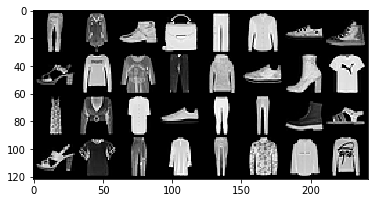

In [4]:
import matplotlib.pyplot as plt

## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

## show images
imshow(torchvision.utils.make_grid(images))

## Sukurti modelį

Čia turite laisvę pasireikšti. 

Čia trumpai aprašykite savo modelio architektūrą.

In [0]:
# source: https://towardsdatascience.com/mnist-handwritten-digits-classification-using-a-convolutional-neural-network-cnn-af5fafbc35e9
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear1 = torch.nn.Linear(7 * 7 * 64, 256)
        self.linear2 = torch.nn.Linear(256, 10)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.relu = torch.nn.ReLU()
    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return F.log_softmax(x,dim=1)

### Mokymo parametrai

Čia turite laisvę pasireikšti. Bet modelis turi išlikti `model`.

In [0]:
learning_rate = 0.001
num_epochs = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Apmokyti

Nieko nekeisti! Apmokymas vyksta tik čia. Epochų skaičius turi būti parinktas taip, kad nebūtų viršytas laikas. 


In [150]:
# timing. do not alter!
start_timer = torch.cuda.Event(enable_timing=True)
end_timer = torch.cuda.Event(enable_timing=True)
start_timer.record()

# training stats
trainlosses = np.zeros(num_epochs)
trainaccs = np.zeros(num_epochs)
validaccs = np.zeros(num_epochs)

for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    
    model.eval()
    train_running_loss /= len(trainloader)
    train_acc /= len(trainloader)

    valid_acc = 0.0
    for i, (images, labels) in enumerate(validloader, 0):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        valid_acc += get_accuracy(outputs, labels, BATCH_SIZE)
    
    valid_acc /= len(validloader)

    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.4f | Validation Accuracy: %.4f' \
          %(epoch, train_running_loss, train_acc, valid_acc)) 
            
    trainlosses[epoch] = train_running_loss
    trainaccs[epoch] = train_acc
    validaccs[epoch] = valid_acc

# timing. do not alter!
end_timer.record()
torch.cuda.synchronize()
elapsed_time = start_timer.elapsed_time(end_timer)
max_training_time = 2*60*1000
print('Training time: %.2f ms (max %i ms.)' %(elapsed_time,max_training_time))  
assert elapsed_time <= max_training_time, 'Training is too long!'

Epoch: 0 | Loss: 0.5102 | Train Accuracy: 0.8161 | Validation Accuracy: 0.8798
Epoch: 1 | Loss: 0.3279 | Train Accuracy: 0.8817 | Validation Accuracy: 0.8986
Epoch: 2 | Loss: 0.2759 | Train Accuracy: 0.8996 | Validation Accuracy: 0.9082
Epoch: 3 | Loss: 0.2451 | Train Accuracy: 0.9107 | Validation Accuracy: 0.9130
Epoch: 4 | Loss: 0.2217 | Train Accuracy: 0.9181 | Validation Accuracy: 0.9145
Epoch: 5 | Loss: 0.2020 | Train Accuracy: 0.9256 | Validation Accuracy: 0.9198
Epoch: 6 | Loss: 0.1874 | Train Accuracy: 0.9296 | Validation Accuracy: 0.9216
Epoch: 7 | Loss: 0.1694 | Train Accuracy: 0.9375 | Validation Accuracy: 0.9221
Epoch: 8 | Loss: 0.1584 | Train Accuracy: 0.9401 | Validation Accuracy: 0.9203
Epoch: 9 | Loss: 0.1446 | Train Accuracy: 0.9455 | Validation Accuracy: 0.9232
Training time: 101494.55 ms (max 120000 ms.)


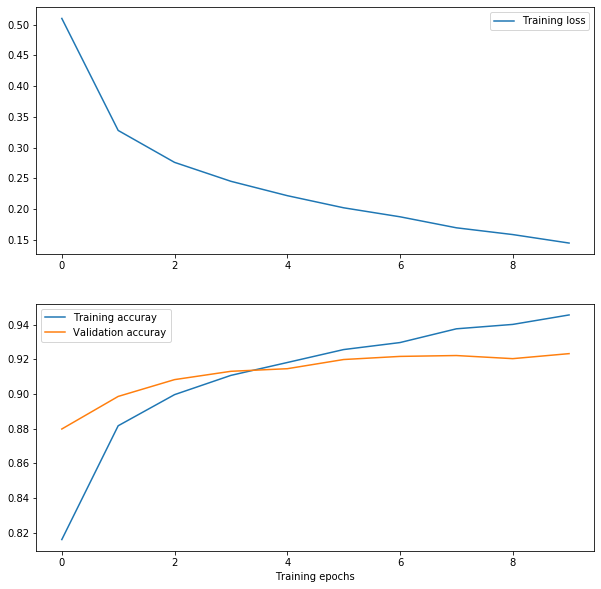

In [152]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(trainlosses)
plt.legend(['Training loss']) 
plt.subplot(2,1,2)
plt.plot(trainaccs)
plt.plot(validaccs)
plt.xlabel('Training epochs')
plt.legend(['Training accuray','Validation accuray'])

## Testavimas

Nieko nekeisti! Ir nežiūrėti ;)

In [153]:
## download and load testing dataset
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

# test
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)

test_acc /= len(testloader)        
print('Test Accuracy: %.4f'%( test_acc ))

Test Accuracy: 0.9114
